In [ ]:
# Mount drive
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/CS454 AI-Based SE/Code'
root = '/gdrive/My Drive/CS454 AI-Based SE/Code'

 alexnet_pytorch_vision.ipynb	       DeepSearchTestEdited.ipynb
'Batch Test GA.ipynb'		      'Genetic Test.ipynb'
'Chi_test (1).ipynb'		       MNIST_for_test.ipynb
 Chi_test.ipynb			       PSO_unfinished.ipynb
 ckpt.pt			       result0.35.png
 ckpts				       result0.3.png
'Copy of Batch Test GA.ipynb'	       result.png
'Copy of DeepSearchTestEdited.ipynb'   results
'Copy of Genetic Test.ipynb'	       results2
'Deep Search - Final.ipynb'	       results3
 deepsearch_result2.txt		       results_mnist
 deepsearch_result.gdoc		       sample_image
 deepsearch_result.txt		      '(version2) alexnet_pytorch_vision.ipynb'


In [ ]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import matplotlib.pyplot as plt
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
from torchvision import transforms
from google.colab.patches import cv2_imshow

In [ ]:
# Load the trained model using MNIST
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet')
# Updating the classifiers
model.features[0] = nn.Conv2d(1, 64, (4, 4), stride=(2,2), padding=(2, 2))
model.classifier[4] = nn.Linear(4096,1024)

# Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(1024,10)
model.load_state_dict(torch.load(root+'/results_mnist/best.pt', map_location=torch.device('cpu')))
# else:
#   model.load_state_dict(torch.load(root+'/results_mnist/best.pt'))
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

# Setup (MNIST)

In [ ]:
# Set hyperparameters
from easydict import EasyDict as edict

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()

# basic options 
# args.name = 'main'                   # experiment name.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_iter = 200               # how frequently checkpoints are saved.
args.ckpt_reload = 'best'            # which checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# data options
args.dataroot = 'dataset/mnist'    # where MNIST images exist.
args.batch_size = 100                # number of mini-batch size.

In [ ]:
result_dir = Path(root) / 'results_mnist'
result_dir.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu' # move the input and model to GPU for speed if available
model = model.to(device)

In [ ]:
import torchvision
train_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

test_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

train_dataset = MNIST(args.dataroot, download=True, train=True, transform=train_transform)
test_dataset = MNIST(args.dataroot, download=True, train=False, transform=test_transform)

# split_train = torch.utils.data.random_split(train_dataset, [100, len(train_dataset)-100])[0]

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)

Extracting dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw



Extracting dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50
tensor([7, 2, 1, 0, 4, 1, 4, 9])


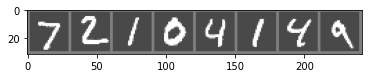

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

print(len(images[:50]))
print(labels[:8])

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels

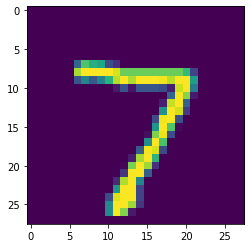

In [ ]:
normimg = images[0] / 2 + 0.5
normimg = normimg.numpy()
plt.imshow(normimg.squeeze())

# Legacy

In [ ]:
import pandas as pd
final_test = pd.read_csv(root+"/sample_image/test.csv", dtype=np.float32)
final_test = final_test.values/255
test_tn = torch.from_numpy(final_test)

In [ ]:
import random

dataset_list = []

for i in range(args.batch_size):
  sample_test = test_tn[random.randint(0, len(test_tn))].view(28, 28)
  sample_test = sample_test.to(device)
  model = model.double()
  output = model(sample_test.unsqueeze(0).unsqueeze(1).double())
  # true_class = output.argmax(1)
  dataset_list.append(sample_test)
  # print(true_class)
  # sample_test = sample_test.cpu()
  # plt.imshow(sample_test)
  # sample_test = sample_test.to(device)

# POBA-GA
Algorithm: POBA-GA

Functions:


*   calc_perturb: Calculate the "loss" of the perturbation in order for the picture to remain rimilar
*   fitness_function: Calculate the fitness of an adversarial example
*   selection: select two parents from a list of population



In [ ]:
def calc_perturb(x):
  pm1 = 10
  pm2 = 5.8
  size = x.size()
  m_a = size[0] # Height
  m_b = size[1] # Width
  total = 0
  for i in range(m_a):
    for j in range(m_b):
      total = total + 1/(1+pow(np.e, -abs(x[i][j])*pm1 + pm2)) - 1/(1+pow(np.e, pm2))
  return total

def fitness_function(x, model, true_label, max_perturb):
  alpha = 1 # Change this later
  # All the labels are a number, indicating the category index
  logits = model(x.unsqueeze(0).unsqueeze(0).double()) # Get the current prediction
  logits = logits.cpu()
  ordered_idx = np.argsort(logits[0].detach().numpy())
  label1 = ordered_idx[-1]
  label2 = ordered_idx[-2]
  logits = logits.to(device)
  if label1 != true_label:
    att_perform = logits[0][label1] - logits[0][true_label]
  else:
    att_perform = logits[0][label2] - logits[0][true_label]

  # print("att_perform ", att_perform)

  if label1 != true_label:
    return att_perform - (alpha/max_perturb) * calc_perturb(x)
  else:
    return att_perform

def fr_roulette(idx, adv_examples, model, true_label, total_fitness, max_perturb):
  def f_roulette(x):
    return fitness_function(x, model, true_label, max_perturb)/total_fitness
  total_roulette = 0
  for i in range(len(adv_examples)):
    if idx > i:
      break
    total_roulette = total_roulette + f_roulette(adv_examples[i])
  return total_roulette

def selection(adv_examples, perturbations, model, true_label, total_f, max_perturb):
  k = np.random.rand()
  i = 0
  while k < fr_roulette(i, adv_examples, model, true_label, total_f, max_perturb):
    i = i + 1
  return perturbations[i]

def crossover(cross_chance, parent1, parent2):
  if np.random.rand() < cross_chance:
    B_matrix = torch.randint(2, size=parent1.size())
    B_matrix = B_matrix.to(device)
    child1 = parent1 * B_matrix + parent2 * (1-B_matrix)
    child2 = parent2 * B_matrix + parent1 * (1-B_matrix)
    return child1, child2
  else:
    return parent1, parent2

def mutation(mutate_chance, adv_ex):
  C_matrix = torch.ones(adv_ex.size())
  C_matrix = C_matrix.to(device)
  # Randomly change some elements to (0, 2)
  for i in range(random.randint(1, 5)): # Currently the number of element changed is random
    i_loc = random.randint(0, adv_ex.size()[0]-1)
    j_loc = random.randint(0, adv_ex.size()[1]-1)
    # Even the channel that is changed is random
    # print(C_matrix.size())
    # print(C_matrix[0].size())
    C_matrix[i_loc][j_loc] = random.uniform(0, 2.0)
    # print("Hello")
  if np.random.rand() < mutate_chance:
    return adv_ex*C_matrix
  else:
    return adv_ex

def get_prediction(image, class_name):
  predict = model(images.double().unsqueeze(0))
  # print(class_name[predict.argmax(1)])
  return predict

### Main Algorithm (Single Image)

In [ ]:
def POBA_GA(input_img, t_model, cross_p, mutate_p, alpha, gen, p_size, thresh=0):
  img_size = input_img.size()
  t_model = t_model.double()
  init_pred = t_model(input_img.double().unsqueeze(0).unsqueeze(0)) #Get the current prediction
  true_label = init_pred.argmax(1)
  perturbation = []
  curr_best = input_img
  for i in range(p_size):
    perturb = torch.rand(img_size)*0.3
    perturb = perturb.to(device)
    perturbation.append(perturb) # TODO! Normalize value
  t = 0
  while model(curr_best.double().unsqueeze(0).unsqueeze(0)).argmax(1) == true_label:
    print("Generation {}/{}".format(t, gen))
    t = t + 1
    # Create the set of adversarial examples by adding pertubation to input image
    adv_examples = [torch.clip(input_img + perturb, 0, 1) for perturb in perturbation] # TODO! May need to clip the value in the img

    # Get the fitness for all adversarial examples
    calc_perturb_list = []
    for i in range(p_size):
      calc_perturb_list.append(calc_perturb(adv_examples[i]))
    max_perturb = max(calc_perturb_list)

    adv_fitness = []  
    for i in range(p_size):
      adv_fitness.append(fitness_function(adv_examples[i], t_model, true_label, max_perturb))
    
    # Get roulette probability
    roulette = []
    for i in range(p_size):
      roulette.append(fr_roulette(i, adv_examples, t_model, true_label, sum(adv_fitness), max_perturb))

    # # If the minimum fitness is reached, break the loop
    # if max(adv_fitness) > thresh:
    #   break;
    new_perturb = []
    for n in range(p_size//2):
      parent1 = selection(adv_examples, perturbation, t_model, true_label, sum(adv_fitness), max_perturb)
      parent2 = selection(adv_examples, perturbation, t_model, true_label, sum(adv_fitness), max_perturb)
      child1, child2 = crossover(cross_p, parent1, parent2)
      child1 = mutation(mutate_p, child1)
      child2 = mutation(mutate_p, child2)
      new_perturb.append(child1)
      new_perturb.append(child2)
    perturbation = new_perturb
    curr_best = adv_examples[adv_fitness.index(max(adv_fitness))]
  return curr_best

### Main Algorithm (Batch)

In [ ]:
import time
def POBA_GA(dataset, t_model, cross_p, mutate_p, alpha, gen, p_size, thresh=0, resume=False):
  t0 = time.time()
  t_model = t_model.double()

  if resume:
    checkpoint = torch.load(ckpt_path)
    num_success = checkpoint['num_success']
    num_total = checkpoint['num_total']
    num_queries = checkpoint['num_queries']
    t_added = checkpoint['t_added']
    j = checkpoint['j']
    successlist = checkpoint['successlist']
    faillist = checkpoint['faillist']
    print(f'Resume training from data {j}')
  else:
    num_success = 0
    num_total = 0
    num_queries = [0]*len(dataset)
    t_added = 0
    j = 0
    successlist = []
    faillist = []

  while j < len(dataset):
    t0_j = time.time()
    num_total += 1
    input_img = dataset[j][0]
    input_img = input_img.to(device)
    img_size = input_img.size()
    init_pred = t_model(input_img.double().unsqueeze(0).unsqueeze(0)) #Get the current prediction
    true_label = init_pred.argmax(1)
    perturbation = []
    curr_best = input_img
    for i in range(p_size):
      perturb = torch.rand(img_size)*0.5
      perturb = perturb.to(device)
      perturbation.append(perturb) # TODO! Normalize value
    t = 0
    while t<gen:
      print("Generation {}/{}".format(t, gen-1))
      t = t + 1
      num_queries[j] += 1
      # Create the set of adversarial examples by adding pertubation to input image
      adv_examples = [torch.clip(input_img + perturb, 0, 1) for perturb in perturbation] # TODO! May need to clip the value in the img
      #print("len adv_examples ", len(adv_examples))

      # Get the fitness for all adversarial examples
      calc_perturb_list = []
      for i in range(p_size):
        #print(i)
        calc_perturb_list.append(calc_perturb(adv_examples[i]))
      max_perturb = max(calc_perturb_list)

      adv_fitness = []  
      for i in range(p_size):
        adv_fitness.append(fitness_function(adv_examples[i], t_model, true_label, max_perturb))
      
      # Get roulette probability
      roulette = []
      for i in range(p_size):
        roulette.append(fr_roulette(i, adv_examples, t_model, true_label, sum(adv_fitness), max_perturb))

      # If the minimum fitness is reached, break the loop
      # if max(adv_fitness) > thresh:
      #   break;
      new_perturb = []
      for n in range(p_size//2):
        parent1 = selection(adv_examples, perturbation, t_model, true_label, sum(adv_fitness), max_perturb)
        parent2 = selection(adv_examples, perturbation, t_model, true_label, sum(adv_fitness), max_perturb)
        child1, child2 = crossover(cross_p, parent1, parent2)
        child1 = mutation(mutate_p, child1)
        child2 = mutation(mutate_p, child2)
        new_perturb.append(child1)
        new_perturb.append(child2)
      perturbation = new_perturb
      #print("new perturb size ", len(perturbation))
      curr_best = adv_examples[adv_fitness.index(max(adv_fitness))]

      if model(curr_best.double().unsqueeze(0).unsqueeze(0)).argmax(1) != true_label:
        num_success += 1
        successlist.append(true_label)
        print(f"Image data {j} successfully attacked")
        break
    
    if t == gen:
      faillist.append(true_label)
      print(f"Image data {j} not successfully attacked")
    t_j = time.time() - t0_j
    t_added += t_j
    j += 1

    # Save checkpoints every iteration.
    checkpoint = {
        'num_success': num_success,
        'num_total': num_total,
        'num_queries': num_queries,
        't_added': t_added,
        'j': j,
        'successlist': successlist,
        'faillist': faillist
    }
    torch.save(checkpoint, ckpt_path)
    
  success_rate = num_success/num_total
  t_spent = time.time() - t0 + t_added
  return success_rate, num_queries, t_spent, successlist, faillist

In [ ]:
ckpt_path = Path(root) / 'ckpts' / 'ckpt.pt'

success_rate, num_queries, t_spent, successlist, faillist = POBA_GA(images[:24], model, 1, 0.1, 0, 20, 40, resume=True)
avg_queries = sum(num_queries)/len(num_queries)
print(f"POBA-GA finished running, success rate: {success_rate:.3f}, average number of queries: {avg_queries},  time taken: {t_spent:.3f} secs")
print(successlist)
print(faillist)

Resume training from data 23
Generation 0/19
Generation 1/19
Generation 2/19
Generation 3/19
Generation 4/19
Generation 5/19
Generation 6/19
Generation 7/19
Generation 8/19
Generation 9/19
Generation 10/19
Generation 11/19
Generation 12/19
Generation 13/19
Generation 14/19
Generation 15/19
Generation 16/19
Generation 17/19
Generation 18/19
Generation 19/19
Image data 23 not successfully attacked
POBA-GA finished running, success rate: 0.042, average number of queries: 9.22,  time taken: 24368.035 secs
[tensor([6], device='cuda:0')]
[tensor([7], device='cuda:0'), tensor([2], device='cuda:0'), tensor([1], device='cuda:0'), tensor([0], device='cuda:0'), tensor([4], device='cuda:0'), tensor([1], device='cuda:0'), tensor([4], device='cuda:0'), tensor([9], device='cuda:0'), tensor([5], device='cuda:0'), tensor([9], device='cuda:0'), tensor([0], device='cuda:0'), tensor([6], device='cuda:0'), tensor([9], device='cuda:0'), tensor([0], device='cuda:0'), tensor([1], device='cuda:0'), tensor([5],

In [ ]:
# result_output = model(result.double().view(1, 1, 28,28))
# print(result_output.argmax(1))
# plt.imshow(result.view(28, 28))
# image_dir = Path(root)
# plt.savefig(f"{image_dir}/result.png")